In [2]:
import torch
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)
model.cuda()

# CifarResNet
# ├── conv1 (3x3, stride=1)
# ├── bn1
# ├── relu
# ├── layer1 (Residual Block, 16 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── Block 2
# │   ├── ...
# │   ├── Block 8
# ├── Layer2 (Residual Block, 32 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── ...
# │   ├── Block 8
# ├── Layer3 (Residual Block, 64 filters)
# │   ├── Block 0
# │   ├── Block 1
# │   ├── ...
# │   ├── Block 8
# ├── avgpool
# └── fc (Fully Connected, 100 classes)


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


unit: BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
unit: BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
unit: BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

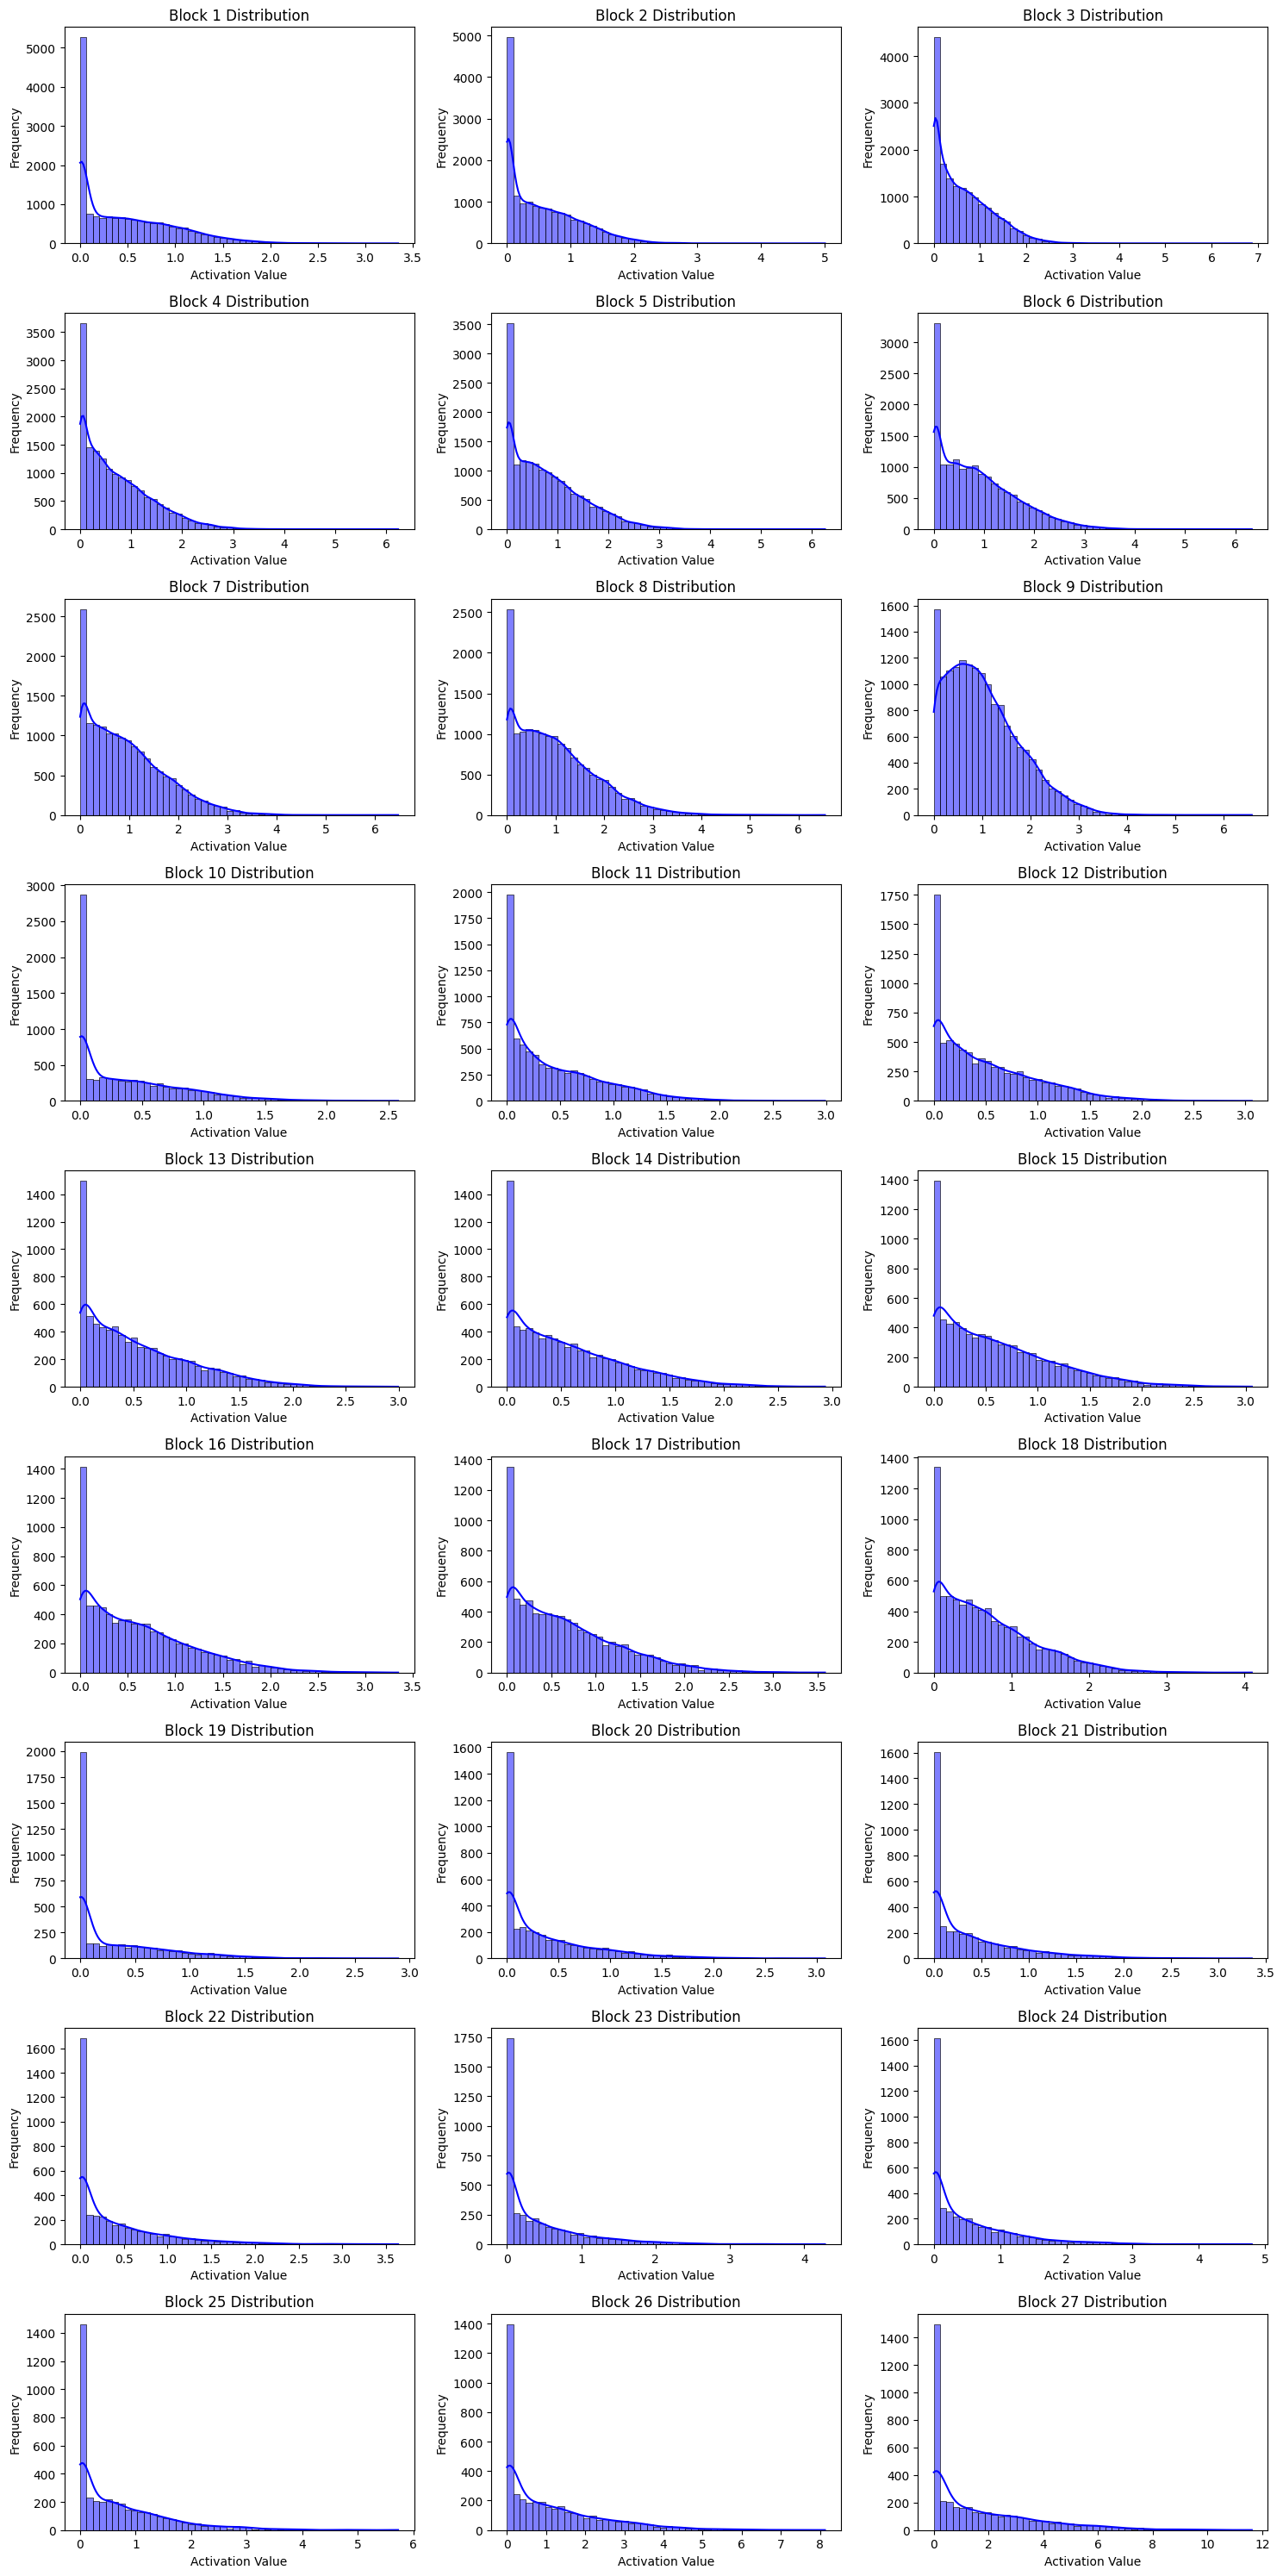

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision.models as models


model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)


# 用來存儲各層輸出的列表
activations = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn(module, input, output):
    activations.append(output)

# 設置鉤子，將鉤子添加到每個 stage 和 unit
hooks = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 遍歷所有 stages 和 units，根據判斷註冊鉤子
for stage_idx, stage in enumerate(model.children()):
    if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
        # print("stage:",stage)
        for unit_idx, unit in enumerate(stage):
            if has_children(unit):
                hook = unit.register_forward_hook(hook_fn)
                hooks.append(hook)
                print("unit:",unit)

print(len(hooks))

# 隨機生成輸入，形狀為 (1, 3, 224, 224)
input_tensor = torch.randn(1, 3, 32, 32)

# 前向傳遞，這將觸發鉤子
model(input_tensor)

# 繪製每個 block 的數據分佈圖（直方圖）
fig, axes = plt.subplots(9, 3, figsize=(15, 30))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
for i in range(min(27, len(activations))):  # 確保最多繪製 32 張圖
    activation = activations[i].cpu().detach().numpy()  # 取得激活並轉換為 numpy 格式
    flattened_activation = activation.flatten()  # 展平為一維數據
    
    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation, kde=True, ax=axes[i], color='blue', bins=50)
    axes[i].set_title(f'Block {i+1} Distribution')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 釋放鉤子
for hook in hooks:
    hook.remove()

In [4]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 32, 32)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 統計信息
stats = []

num_plots = min(27, len(activations_pretrained_copy))

for i in range(num_plots):  
    # 取得預訓練激活並轉換為 numpy 格式
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()
    flattened_activation_pretrained = activation_pretrained.flatten()

    # 計算均值和標準差
    mean_pretrained = np.mean(flattened_activation_pretrained)
    std_pretrained = np.std(flattened_activation_pretrained)

    # 獲取輸出形狀
    output_shape = activation_pretrained.shape

    # 存儲統計信息
    stats.append([i+1, output_shape, mean_pretrained, std_pretrained])

# 創建 DataFrame 並顯示
columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained']
df_stats = pd.DataFrame(stats, columns=columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Activation Statistics", dataframe=df_stats)  # 顯示數據表格

display(df_stats.style.hide(axis="index"))



27


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


block_index,output shape,mean of pretrained,std of pretrained
1,"(1, 16, 32, 32)",0.478172,0.494713
2,"(1, 16, 32, 32)",0.558783,0.560274
3,"(1, 16, 32, 32)",0.631877,0.599572
4,"(1, 16, 32, 32)",0.710743,0.657229
5,"(1, 16, 32, 32)",0.783807,0.697344
6,"(1, 16, 32, 32)",0.862928,0.750115
7,"(1, 16, 32, 32)",0.937994,0.774512
8,"(1, 16, 32, 32)",0.994266,0.816668
9,"(1, 16, 32, 32)",1.028014,0.750945
10,"(1, 32, 16, 16)",0.389490,0.433102


# KS Test

In [28]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import time  # 加在最上面
start_time = time.time()  # 開始時間

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
# set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # Mannwhitneyu
    # u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

    # KS
    u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
    sig_pre = "*" if p_val_pre < 0.05 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, sig_pre, p_val_pre])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'sig of pretrained', 'p_val_pre']
df_stats = pd.DataFrame(rows, columns=columns)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(df_stats.style.hide(axis="index"))



Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


27

Total elapsed time: 1.22 seconds


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,p_val_pre
1,"torch.Size([1, 16, 32, 32])",0.542360,0.534350,*,0.000000
2,"torch.Size([1, 16, 32, 32])",0.611271,0.563869,*,0.000000
3,"torch.Size([1, 16, 32, 32])",0.681679,0.611370,*,0.000000
4,"torch.Size([1, 16, 32, 32])",0.758849,0.656810,*,0.000000
5,"torch.Size([1, 16, 32, 32])",0.837136,0.708050,*,0.000000
6,"torch.Size([1, 16, 32, 32])",0.905668,0.721140,*,0.000000
7,"torch.Size([1, 16, 32, 32])",0.956830,0.751672,*,0.000003
8,"torch.Size([1, 16, 32, 32])",1.000643,0.702886,*,0.000000
9,"torch.Size([1, 32, 16, 16])",0.370709,0.403811,*,0.000000
10,"torch.Size([1, 32, 16, 16])",0.433867,0.425450,*,0.000000


# 二次檢定

In [6]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import time  # 加在最上面
start_time = time.time()  # 開始時間

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
# set_seed(5)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    elif hook_fn == hook_fn_finetuned:
        activations_finetuned.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    # input_tensor = torch.empty(1, 3, 32, 32, device=device).uniform_(-1, 1)

    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model.to(device)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)

    for i in range(4, 1, -1):  # 逆向刪除，避免索引錯亂
        del model.layer3[i]

    path = "/ssd5/Roy/pytorch_resnet_cifar10-master/save_resnet56_cifar100/KS/best_model.th"

    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

    # 移除 "module." 前綴
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # 移除 module.
        new_state_dict[new_key] = value

    # 加載到模型
    model.load_state_dict(new_state_dict)

    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    act_before_pre = remove_outliers(act_before_pre)
    act_after_pre = remove_outliers(act_after_pre)

    # Mannwhitneyu
    u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

    # KS
    u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
    sig_pre = "*" if p_val_pre < 0.05 else ""
    # sig_pre = "*" if p_val_pre < 0.00192 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, sig_pre, p_val_pre])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'sig of pretrained', 'p_val_pre']
df_stats = pd.DataFrame(rows, columns=columns)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(df_stats.style.hide(axis="index"))



Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
/tmp/ipykernel_278174/2690513747.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

24

Total elapsed time: 4.23 seconds


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,p_val_pre
1,"torch.Size([1, 16, 32, 32])",0.146104,0.132065,*,0.000000
2,"torch.Size([1, 16, 32, 32])",0.156991,0.141109,*,0.000000
3,"torch.Size([1, 16, 32, 32])",0.179121,0.158882,*,0.000000
4,"torch.Size([1, 16, 32, 32])",0.190228,0.165761,*,0.000000
5,"torch.Size([1, 16, 32, 32])",0.210790,0.176555,*,0.000000
6,"torch.Size([1, 16, 32, 32])",0.224937,0.172310,*,0.000000
7,"torch.Size([1, 16, 32, 32])",0.221878,0.180981,*,0.000000
8,"torch.Size([1, 16, 32, 32])",0.237011,0.162986,*,0.000000
9,"torch.Size([1, 32, 16, 16])",0.099005,0.105913,*,0.000000
10,"torch.Size([1, 32, 16, 16])",0.119163,0.111706,*,0.000000


# 距離方法 EMD

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import wasserstein_distance, entropy  # 用於計算 EMD 和 KL 散度
from scipy.spatial.distance import jensenshannon  # JS 散度
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(5)

device = torch.device("cpu")

activations_pretrained = []

def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

def has_children(module):
    return len(list(module.children())) > 0

def get_activations_from_model(model, hook_fn, hooks, weights=None):
    activations_pretrained.clear()

    if weights:
        checkpoint = torch.load(weights, weights_only=True, map_location=device)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    for stage in model.children():
        if isinstance(stage, torch.nn.Sequential):
            for unit in stage:
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model(input_tensor)

    for hook in hooks:
        hook.remove()

def load_pretrained_model():
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)
    return model

def emd_distance(features1, features2):
    return wasserstein_distance(features1.flatten(), features2.flatten())

def to_probability_minmax(features):
    features = (features - np.min(features)) / (np.max(features) - np.min(features) + 1e-10)
    return features / np.sum(features)

def total_variation_distance(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return 0.5 * np.sum(np.abs(p1 - p2))

def js_divergence(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return jensenshannon(p1, p2)

def kl_divergence(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return entropy(p1 + 1e-10, p2 + 1e-10)

def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]

pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, [])
activations_pretrained_copy = activations_pretrained.copy()

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre = activations_pretrained_copy[i].numpy().flatten()

    # act_before_pre = remove_outliers(act_before_pre)
    # act_after_pre = remove_outliers(act_after_pre)

    emd_pre = emd_distance(act_before_pre, act_after_pre)
    tv_pre = total_variation_distance(act_before_pre, act_after_pre)
    js_pre = js_divergence(act_before_pre, act_after_pre)
    kl_pre = kl_divergence(act_before_pre, act_after_pre)

    sig_pre = "*" if emd_pre > 0.025 else ""
    # sig_pre = "*" if tv_pre > 0.1 else ""
    # sig_pre = "*" if js_pre > 0.15 else ""
    # sig_pre = "*" if kl_pre > 0.2 else ""

    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, emd_pre, tv_pre, js_pre, kl_pre, sig_pre])

columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained', 
           'EMD of pretrained', 'TV of pretrained', 'JS of pretrained', 'KL of pretrained', 'sig_pre']
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


block_index,output shape,mean of pretrained,std of pretrained,EMD of pretrained,TV of pretrained,JS of pretrained,KL of pretrained,sig_pre
1,"torch.Size([1, 16, 32, 32])",0.558783,0.560274,0.080611,0.084718,0.127631,0.111100,*
2,"torch.Size([1, 16, 32, 32])",0.631877,0.599572,0.073094,0.082269,0.128285,0.118256,*
3,"torch.Size([1, 16, 32, 32])",0.710743,0.657229,0.079573,0.071848,0.106424,0.089423,*
4,"torch.Size([1, 16, 32, 32])",0.783807,0.697344,0.073762,0.071297,0.105179,0.094314,*
5,"torch.Size([1, 16, 32, 32])",0.862928,0.750115,0.079125,0.055956,0.078552,0.047014,*
6,"torch.Size([1, 16, 32, 32])",0.937994,0.774512,0.075066,0.065764,0.097269,0.053684,*
7,"torch.Size([1, 16, 32, 32])",0.994266,0.816668,0.057118,0.050725,0.077953,0.059931,*
8,"torch.Size([1, 16, 32, 32])",1.028014,0.750945,0.064992,0.079466,0.121816,0.086286,*
9,"torch.Size([1, 32, 16, 16])",0.389490,0.433102,0.638524,9999999.000000,9999999.000000,9999999.000000,*
10,"torch.Size([1, 32, 16, 16])",0.453435,0.457335,0.063945,0.113184,0.169703,0.174287,*


# 熵

In [1]:
import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from PIL import Image
import torchvision.transforms as T
import random
import time

# 時間開始
start_time = time.time()

# 固定隨機種子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_seed(5)

# 裝置設定
device = torch.device("cpu")

# 儲存 activation
activations_pretrained = []

def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

# 判斷是否有子模組
def has_children(module):
    return len(list(module.children())) > 0

# 載入 CIFAR10 預訓練模型
def load_pretrained_model():
    import os
    import sys
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    import resnet_cifar100
    arch = "resnet56"
    model = resnet_cifar100.__dict__[arch]()
    path = os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/save_resnet56_cifar100/best_model.th')
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    return model

# 加入 hook 並執行一次 forward
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    activations_pretrained.clear()

    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    for stage in model.children():
        if isinstance(stage, torch.nn.Sequential):
            for unit in stage:
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model.to(device)
    model(input_tensor)

    for hook in hooks:
        hook.remove()

# 計算 Shannon 熵
def compute_entropy(x):
    hist, _ = np.histogram(x, bins=256, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

# 模型與 activation
hooks_pretrained = []
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()

# 計算 cosine similarity 與 entropy 差異
from numpy.linalg import norm

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    if i in [9, 18]:  # 跳過第9與18層（即9-10與18-19）
        continue

    act_before = activations_pretrained_copy[i - 1].numpy().flatten()
    act_after = activations_pretrained_copy[i].numpy().flatten()

    # 熵
    entropy_before = compute_entropy(act_before)
    entropy_after = compute_entropy(act_after)
    entropy_diff = entropy_after - entropy_before

    # Cosine similarity
    cos_sim = np.dot(act_before, act_after) / (norm(act_before) * norm(act_after) + 1e-8)

    mean_pre = np.mean(act_after)
    std_pre = np.std(act_after)
    output_shape = activations_pretrained_copy[i].shape

    rows.append([i, output_shape, mean_pre, std_pre, entropy_before, entropy_after, entropy_diff, cos_sim])

# 結果表格
columns = ['block_index', 'output_shape', 'mean', 'std',
           'entropy_before', 'entropy_after', 'entropy_diff',
           'cosine_similarity']

df_stats = pd.DataFrame(rows, columns=columns)

# 執行時間
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

# 顯示
display(df_stats.style.hide(axis="index"))


/tmp/ipykernel_1354591/4168875650.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Total elapsed time: 2.55 seconds


block_index,output_shape,mean,std,entropy_before,entropy_after,entropy_diff,cosine_similarity
1,"torch.Size([1, 16, 32, 32])",0.356720,0.364007,-127.109296,-53.385216,73.724080,0.968885
2,"torch.Size([1, 16, 32, 32])",0.413352,0.414261,-53.385216,-24.900897,28.484318,0.984801
3,"torch.Size([1, 16, 32, 32])",0.456016,0.450077,-24.900897,-8.100534,16.800363,0.989842
4,"torch.Size([1, 16, 32, 32])",0.504198,0.469608,-8.100534,23.579336,31.679870,0.991823
5,"torch.Size([1, 16, 32, 32])",0.551577,0.507842,23.579336,27.554683,3.975347,0.994750
6,"torch.Size([1, 16, 32, 32])",0.599784,0.530925,27.554683,37.418575,9.863892,0.992013
7,"torch.Size([1, 16, 32, 32])",0.643388,0.511749,37.418575,49.764865,12.346290,0.983446
8,"torch.Size([1, 16, 32, 32])",0.674445,0.504645,49.764865,55.247811,5.482946,0.984378
10,"torch.Size([1, 32, 16, 16])",0.438970,0.502944,-32.375302,-7.987587,24.387715,0.990562
11,"torch.Size([1, 32, 16, 16])",0.469267,0.508620,-7.987587,-1.307959,6.679628,0.989108


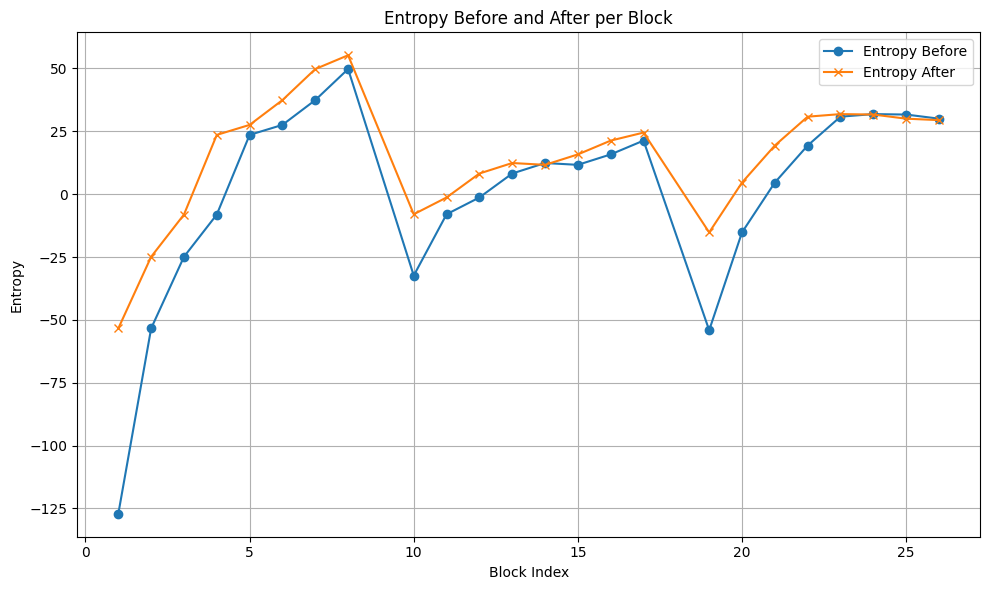

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_stats['block_index'], df_stats['entropy_before'], label='Entropy Before', marker='o')
plt.plot(df_stats['block_index'], df_stats['entropy_after'], label='Entropy After', marker='x')
plt.xlabel('Block Index')
plt.ylabel('Entropy')
plt.title('Entropy Before and After per Block')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


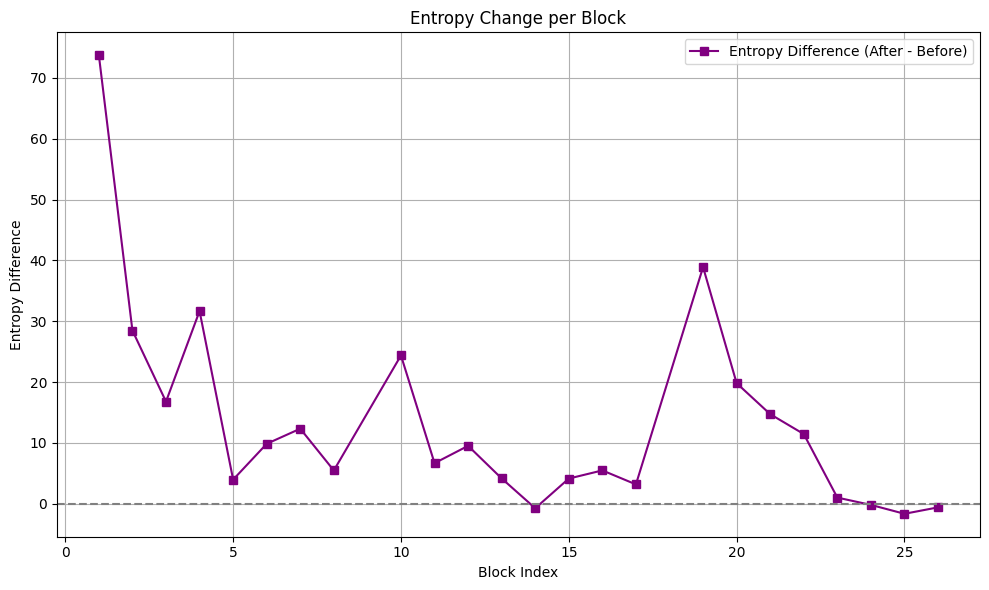

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df_stats['block_index'], df_stats['entropy_diff'], label='Entropy Difference (After - Before)', color='purple', marker='s')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Block Index')
plt.ylabel('Entropy Difference')
plt.title('Entropy Change per Block')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


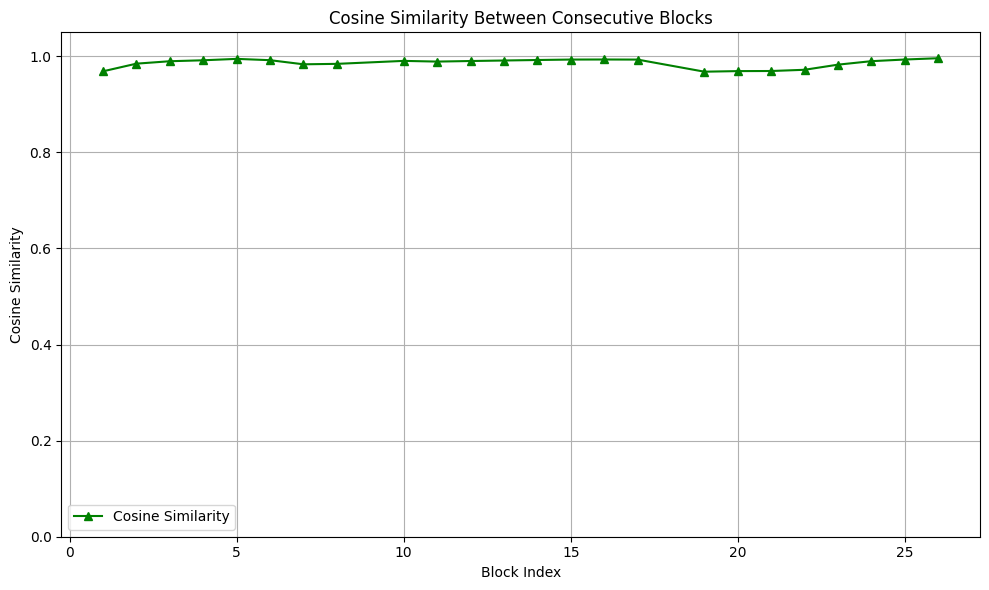

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df_stats['block_index'], df_stats['cosine_similarity'], label='Cosine Similarity', color='green', marker='^')
plt.xlabel('Block Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Between Consecutive Blocks')
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 雖然不直接用到但必須導入
from matplotlib import cm
import numpy as np
import os

# 建立資料夾以儲存圖片
os.makedirs("feature_map_3d", exist_ok=True)

for idx, activation in enumerate(activations_pretrained_copy):
    # activation shape: (C, H, W)
    c, h, w = activation.shape

    # 選擇第0個 channel
    feature = activation[0].numpy()  # shape: (H, W)

    # 建立座標
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    Z = feature

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False)

    ax.set_title(f'Block {idx} - Channel 0')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Activation')

    plt.tight_layout()
    plt.savefig(f'feature_map_3d/block_{idx:02d}_ch0.png')
    plt.close()


ValueError: too many values to unpack (expected 3)